In [1]:
import torch

import numpy as np
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

import matplotlib.pyplot as plt

from src.mlx.models.gpt_mlx import GPT
from src.mlx.models.gpt_mlx import generate_attention_mask
from src.mlx.models.gpt_mlx import GPTParams
from src.mlx.utils.mlx_lm_dataset import LanguageModelingDataset

from src.tokenizers.tokenizer import Tokenizer

from tqdm.notebook import tqdm

from functools import partial

In [2]:
tokenizer = Tokenizer.from_pretrained("tokenizers/tokenizer_ru_toxics/")

In [3]:
params = GPTParams(
    vocab_size=len(tokenizer.vocab),
    context_size=128,
    input_dim=312,
    query_dim=32,
    value_dim=32,
    feed_forward_hidden_dim=1024,
    n_heads=4,
    n_decoder_blocks=6,
)

BATCH_SIZE = 128
N_EPOCHS = 100
LEARNING_RATE = 2e-3
MASK = generate_attention_mask(params.context_size - 1)

In [4]:
tokens = torch.load("preprocessed_datasets/ru_toxics_tokens")
tokens = mx.array(tokens.tolist())

dataset = LanguageModelingDataset(tokens)

In [5]:
model = GPT(params)
optimizer = optim.Adam(learning_rate=LEARNING_RATE)

In [6]:
def loss_func(model, inputs, labels):
    logits = model(inputs, MASK)
    logits = logits.reshape(-1, logits.shape[2])
    
    return mx.mean(nn.losses.cross_entropy(logits, labels.flatten()))


state = [model.state, optimizer.state]

@partial(mx.compile, inputs=state, outputs=state)
def step(inputs, labels):
    loss_and_grad_fn = nn.value_and_grad(model, loss_func)
    loss, grads = loss_and_grad_fn(model, inputs, labels)
    optimizer.update(model, grads)
    return loss

In [7]:
losses = []

for epoch in tqdm(range(N_EPOCHS)):
    for batch in tqdm(dataset.to_dataloader(batch_size=BATCH_SIZE), total=np.ceil(len(dataset) / BATCH_SIZE).astype(int)):
        inputs, labels = batch
        inputs, labels = mx.array(inputs), mx.array(labels)

        loss = step(inputs, labels)

        mx.eval(state)
        losses.append(loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

KeyboardInterrupt: 

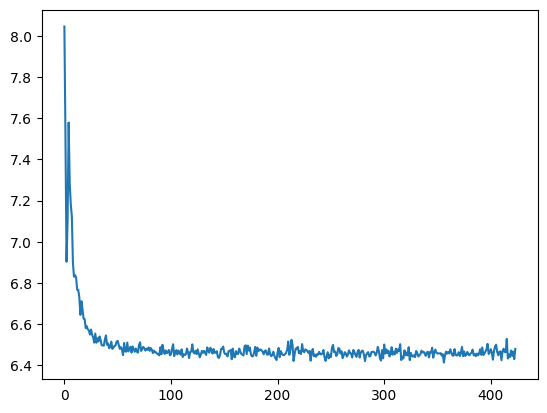

In [8]:
plt.plot(losses)
plt.show()